In [ ]:
%pip install Riskfolio-Lib

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import riskfolio as rp

In [27]:
data_inicial = 13
data_final   = data_inicial + 192
colunas = 291
step_port = 1
step_eval = 1

#IBX: índice Brasil, índice da Bolsa de Valores de São Paulo que avalia o retorno
#de uma carteira teoricamente composta pelas cem ações mais negociadas na BM&FBovespa
comp_indice=pd.read_excel('Dados-Comp-IBRX.xlsx', engine='openpyxl')
comp_indice.set_index(keys = 'Data', inplace = True)

#Últimos preços negociados nas sessões
fechamento=pd.read_excel('Dados-Fechamento.xlsx', engine='openpyxl')
fechamento.set_index(keys = 'Data', inplace = True)

#Indices de referência para comparações (Ibov, IBX, SELIC...)
referencias=pd.read_excel('Dados-Base.xlsx', engine='openpyxl')
referencias.set_index(keys = 'Data', inplace = True)

#---
#Definição dos fatores e criação de um dataframe de ranqueamento dos fatores de acordo com o roic em cada mês
#---

# Fator Qualidade (ROIC das empresas)
fator_ROIC=pd.read_excel('Dados-ROIC-A2.xlsx', engine='openpyxl')
fator_ROIC.set_index(keys = 'Data', inplace = True)
ranked_ROIC=fator_ROIC.rank(axis=1, numeric_only=True, ascending=False, method='first')

# Fator Momentum (Momentum de 12 meses)
fator_Mom=pd.read_excel('Dados-Momentum-12.xlsx', engine='openpyxl')
fator_Mom.set_index(keys = 'Data', inplace = True)
ranked_Mom=fator_Mom.rank(axis=1, numeric_only=True, ascending=False, method='first')

#Fator Tamanho (Valor de mercado das empresas)
fator_Val_Merc=pd.read_excel('Dados-Val-Merc.xlsx', engine='openpyxl')
fator_Val_Merc.set_index(keys = 'Data', inplace = True)
ranked_Val_Merc=fator_Val_Merc.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Valor (Preço / Valor Patrimonial)
fator_PVP=pd.read_excel('Dados-PVP.xlsx', engine='openpyxl')
fator_PVP.set_index(keys = 'Data', inplace = True)
ranked_PVP=fator_PVP.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Volatilidade (Volatilidade em 12 meses)
fator_Vol=pd.read_excel('Dados-Vol-12.xlsx', engine='openpyxl')
fator_Vol.set_index(keys = 'Data', inplace = True)
ranked_Vol=fator_Vol.rank(axis=1, numeric_only=True, ascending=True, method='first')

print("Periodo de avaliacao - de:", comp_indice.index[data_inicial], "(", data_inicial, ")",
      "ate:", comp_indice.index[data_final-1], "(", data_final-1, ")")
print("Rebalanceamento a cada", step_eval,"/", step_port, "meses")

Periodo de avaliacao - de: Jan-2005 ( 13 ) ate: Dez-2020 ( 204 )
Rebalanceamento a cada 1 / 1 meses


In [28]:
#Definição para portifólio com 2 fatores (caso para menos volatilidade)
def Portifolio2Parametros(ranked_1, param_1, ranked_2, param_2): #Seleção dos parâmetros
  port_ranked_final = ranked_1.copy()
  port_ranked_final.loc[:, :] = 0

  for lin in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranked_1.iat[lin-1, col]  >= 1) and (ranked_1.iat[lin-1, col]  <= param_1) and
          (ranked_2.iat[lin-1, col]  >= 1) and (ranked_2.iat[lin-1, col]  <= param_2)):
        port_ranked_final.iat[lin-1, col] = 1

  return port_ranked_final #Retorna o portifólio de 2 fatores

#Definição para portifólio com 3 fatores (caso para maior rentabilidade)
def Portifolio3Parametros(ranked_1, param_1, ranked_2, param_2, ranked_3, param_3): #Seleção dos parâmetros
  port_ranked_final = ranked_1.copy()
  port_ranked_final.loc[:, :] = 0

  for lin in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranked_1.iat[lin-1, col]  >= 1) and (ranked_1.iat[lin-1, col]  <= param_1) and
          (ranked_2.iat[lin-1, col]  >= 1) and (ranked_2.iat[lin-1, col]  <= param_2) and
          (ranked_3.iat[lin-1, col]  >= 1) and (ranked_3.iat[lin-1, col]  <= param_3)):
        port_ranked_final.iat[lin-1, col] = 1

  return port_ranked_final #Retorna o portifólio de 3 fatores

def EvalPort(port, fechamento): #Definição para realização de cálculos
    port_acc_vet = []
    port_chg_vet = []
    port_ddown_vet = []

    port_acc = 1.0
    port_acc_vet.append(1.0)
    cost_trans = 0.0006
    #cost_trans = 0.0005 + (0.004*step_eval/12)

    for lin in range(data_inicial, data_final, step_eval):
        cont = 0.0
        rent = 0.0
        for col in range(0, colunas):
            if (port.iat[lin-1, col] > 0 and fechamento.iat[lin-1, col]>0 and fechamento.iat[lin-1+step_eval, col]>0):
                rent = rent + (fechamento.iat[lin-1+step_eval,col]/fechamento.iat[lin-1,col]-1)*(port.iat[lin-1, col])
                cont = cont + port.iat[lin-1, col]
        if (cont == 0):
          return [1,1], [1,1], [0,0], 0, 0.000001
        port_acc = port_acc * (1.0 + rent/cont - cost_trans)
        port_chg_vet.append(rent/cont - cost_trans)
        port_acc_vet.append(port_acc)
        port_ddown_vet.append(port_acc/(np.max(port_acc_vet))-1)

    ret_aa = pow(port_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(port_chg_vet)*((12/step_eval)**(1/2))
    return port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa #Retorno dos valores calculados

def EvalRef(ref, ind): #Definição para realização de cálculos das referências
    ref_acc_vet = []
    ref_chg_vet = []
    ref_ddown_vet = []

    ref_acc = 1.0
    ref_acc_vet.append(1.0)

    for lin in range(data_inicial, data_final, step_eval):
        rent = ref.iat[lin-1+step_eval,ind]/ref.iat[lin-1,ind]
        ref_acc = ref_acc * rent
        ref_chg_vet.append(rent-1)
        ref_acc_vet.append(ref_acc)
        ref_ddown_vet.append(ref_acc/(np.max(ref_acc_vet))-1)

    ret_aa = pow(ref_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(ref_chg_vet)*((12/step_eval)**(1/2))
    return ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa, vol_aa #Retorno dos valores calculados


In [29]:

def calc_riskfolio_opt (ranked, otim_opt): #Recebe o portifólio e seleciona a otimização desejada
  hist_size = 24
  port = ranked.copy()

  if (otim_opt == 'RP'): #Portifólio de Paridade de Risco
    print("\nCálculo do Portifólio de Paridade de Risco")
  elif (otim_opt == 'GMV'): #Portifólio de Mínima Variância
    print("\nCálculo do Portifólio de Mínima Variância")
  elif (otim_opt == 'MDP'): #Portifólio de Máxima Descorrelação
    print("\nCálculo do Portifólio de Máxima Descorrelação")
  else:
    print("\nOpcao Invalida.")

  for lin in range(data_inicial+hist_size, data_final, 1):
    print("\r",lin, "/", data_final-1, end=' ')
    port_comp = pd.DataFrame()
    for col in range(0, colunas):
      if (port.iat[lin-1, col] > 0):
        port_comp[port.columns[col]]=fechamento[port.columns[col]].iloc[lin-1-hist_size:lin-1]

    port_comp_chg = port_comp.pct_change().dropna()

    #Processo de otimização do Portifólio de Paridade de Risco
    if (otim_opt == 'RP'):
      rp_port = rp.Portfolio(returns=port_comp_chg)
      rp_port.assets_stats()
      w = rp_port.rp_optimization(rm='MV', b = None)

    #Processo de otimização do Portifólio de Mínima Variância
    elif (otim_opt == 'GMV'):
      gmv_port = rp.Portfolio(returns=port_comp_chg)
      gmv_port.assets_stats()
      w = gmv_port.optimization(model='Classic', rm='MV', obj='MinRisk')

    #Processo de otimização do Portifólio de Máxima Descorrelação
    elif (otim_opt == 'MDP'):
      mdp_port = rp.Portfolio(returns=port_comp_chg)
      mdp_port.assets_stats()
      mdp_port.cov = port_comp_chg.corr()
      w = mdp_port.optimization(model='Classic', rm='MV', obj='MinRisk')

    port_len = len(port_comp_chg.columns)
    for at in range(port_len):
      port.at[port.index[lin-1], port_comp.columns[at]] = w['weights'].iat[at]

  port_final = port.copy()
  return port_final

In [30]:
# Cálculos de rentabilidade / volatilidade / drawdown da SELIC
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 2)
print("Ref SELIC:\nRentabilidade Acumulada:",round(ref_acc_vet[-1]*100-100, 2) ,"% ; Rentabilidade Anualizada:",
      round(ret_aa_ref*100,2), "% ; \nVolatilidade Anualizada:", round(vol_aa_ref*100,2), "% ; Rentabilidade por Volatilidade:",
      round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%.")

# Cálculos de rentabilidade / volatilidade / drawdown do Ibovespa
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 0)
print("Ref Ibov:\nRentabilidade Acumulada:",round(ref_acc_vet[-1]*100-100, 2) ,"% ; Rentabilidade Anualizada:",
      round(ret_aa_ref*100,2), "% ; \nVolatilidade Anualizada:", round(vol_aa_ref*100,2), "% ; Rentabilidade por Volatilidade:",
      round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%.")

# Cálculos de rentabilidade / volatilidade / drawdown do IBX
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 1)
print("Ref IBX:\nRentabilidade Acumulada:",round(ref_acc_vet[-1]*100-100, 2) ,"% ; Rentabilidade Anualizada:",
      round(ret_aa_ref*100,2), "% ; \nVolatilidade Anualizada:", round(vol_aa_ref*100,2), "% ; Rentabilidade por Volatilidade:",
      round(ret_aa_ref/vol_aa_ref, 2), "Drawdown:", round(np.min(ref_ddown_vet)*100,2), "%.")

Ref SELIC:
Rentabilidade Acumulada: 397.54 % ; Rentabilidade Anualizada: 10.55 % ; 
Volatilidade Anualizada: 1.05 % ; Rentabilidade por Volatilidade: 10.04 DDown: 0.0 %.
Ref Ibov:
Rentabilidade Acumulada: 354.33 % ; Rentabilidade Anualizada: 9.92 % ; 
Volatilidade Anualizada: 23.45 % ; Rentabilidade por Volatilidade: 0.42 DDown: -49.59 %.
Ref IBX:
Rentabilidade Acumulada: 546.22 % ; Rentabilidade Anualizada: 12.37 % ; 
Volatilidade Anualizada: 22.69 % ; Rentabilidade por Volatilidade: 0.55 Drawdown: -49.74 %.


In [31]:
# Criação do portifólio 1 (foco em rentabilidade)
# Fatores: Qualidade (45), Valor (40), Volatilidade (60)
Port1 = Portifolio3Parametros(ranked_ROIC, 45, ranked_PVP, 40, ranked_Vol, 60)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(Port1, fechamento)
print("\nPortifólio 1:\nRentabilidade Acumulada:",
      round(port_acc_vet1[-1]*100-100, 2) , "% ; Rentabilidade Anualizada:",round(ret_aa1*100,2),
      "% ;\nVolatilidade Anualizada:", round(vol_aa1*100,2), "% ; Rentabilidade por Volatilidade:",
      round(ret_aa1/vol_aa1, 2), "; Drawdown:", round(np.min(port_ddown_vet1)*100,2), "%.")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet1, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Portifólio 1:
Rentabilidade Acumulada: 4240.95 % ; Rentabilidade Anualizada: 26.58 % ;
Volatilidade Anualizada: 22.54 % ; Rentabilidade por Volatilidade: 1.18 ; Drawdown: -32.46 %.
Port Alpha: 15.76 %, Beta: 0.74


In [32]:
# Criação do portifólio 2 (foco em baixa volatilidade)
# Fatores: Qualidade (40), Volatilidade (25)
Port2 = Portifolio2Parametros(ranked_ROIC, 40, ranked_Vol, 25)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(Port2, fechamento)
print("\nPortifólio 2:\nRentabilidade Acumulada:",
      round(port_acc_vet2[-1]*100-100, 2) , "% ; Rentabilidade Anualizada:",round(ret_aa2*100,2),
      "% ;\nVolatilidade Anualizada:", round(vol_aa2*100,2), "% ; Rentabilidade por Volatilidade:",
      round(ret_aa2/vol_aa2, 2), "; Drawdown:", round(np.min(port_ddown_vet2)*100,2), "%.")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet2, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Portifólio 2:
Rentabilidade Acumulada: 981.66 % ; Rentabilidade Anualizada: 16.05 % ;
Volatilidade Anualizada: 16.03 % ; Rentabilidade por Volatilidade: 1.0 ; Drawdown: -28.28 %.
Port Alpha: 8.05 %, Beta: 0.57


In [ ]:
port_riskfolio = calc_riskfolio_opt(Port1, 'RP') #Otimizando o portifólio 1 pela Paridade de Risco
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRentabilidade Acumulada:",round(port_acc_vet3[-1]*100-100, 2) ,"% Rentabilidade Anualizada:",
      round(ret_aa3*100,2), "% \nVolatilidade Anualizada:", round(vol_aa3*100,2), "% Rentabilidade por Volatilidade:",
      round(ret_aa3/vol_aa3, 2), "Drawdown:", round(np.min(port_ddown_vet3)*100,2), "%")

beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet3, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(Port1, 'GMV') #Otimizando o portifólio 1 pela Mínima Variância
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRentabilidade Acumulada:",round(port_acc_vet4[-1]*100-100, 2) ,"% Rentabilidade Anualizada:",
      round(ret_aa4*100,2), "% \nVolatilidade Anualizada:", round(vol_aa4*100,2), "% Rentabilidade por Volatilidade:",
      round(ret_aa4/vol_aa4, 2), "Drawdown:", round(np.min(port_ddown_vet4)*100,2), "%")

beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(Port1, 'MDP') #Otimizando o portifólio 1 pela Máxima Descorrelação
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRentabilidade Acumulada:",round(port_acc_vet5[-1]*100-100, 2) ,"% Rentabilidade Anualizada:",
      round(ret_aa5*100,2), "% \nVolatilidade Anualizada:", round(vol_aa5*100,2), "% Rentabilidade por Volatilidade:",
      round(ret_aa5/vol_aa5, 2), "Drawdown:", round(np.min(port_ddown_vet5)*100,2), "%")

beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

In [ ]:
port_riskfolio = calc_riskfolio_opt(Port2, 'RP') #Otimizando o portifólio 1 pela Paridade de Risco
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRentabilidade Acumulada:",round(port_acc_vet6[-1]*100-100, 2) ,"% Rentabilidade Anualizada:",
      round(ret_aa6*100,2), "% \nVolatilidade Anualizada:", round(vol_aa6*100,2), "% Rentabilidade por Volatilidade:",
      round(ret_aa6/vol_aa6, 2), "Drawdown:", round(np.min(port_ddown_vet6)*100,2), "%")

beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(Port2, 'GMV') #Otimizando o portifólio 1 pela Mínima Variância
port_acc_vet7, port_chg_vet7, port_ddown_vet7, ret_aa7, vol_aa7 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRentabilidade Acumulada:",round(port_acc_vet7[-1]*100-100, 2) ,"% Rentabilidade Anualizada:",
      round(ret_aa7*100,2), "% \nVolatilidade Anualizada:", round(vol_aa7*100,2), "% Rentabilidade por Volatilidade:",
      round(ret_aa7/vol_aa7, 2), "Drawdown:", round(np.min(port_ddown_vet7)*100,2), "%")

beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet7, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(Port2, 'MDP') #Otimizando o portifólio 1 pela Máxima Descorrelação
port_acc_vet8, port_chg_vet8, port_ddown_vet8, ret_aa8, vol_aa8 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRentabilidade Acumulada:",round(port_acc_vet8[-1]*100-100, 2) ,"% Rentabilidade Anualizada:",
      round(ret_aa8*100,2), "% \nVolatilidade Anualizada:", round(vol_aa8*100,2), "% Rentabilidade por Volatilidade:",
      round(ret_aa8/vol_aa8, 2), "Drawdown:", round(np.min(port_ddown_vet8)*100,2), "%")

beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet8, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

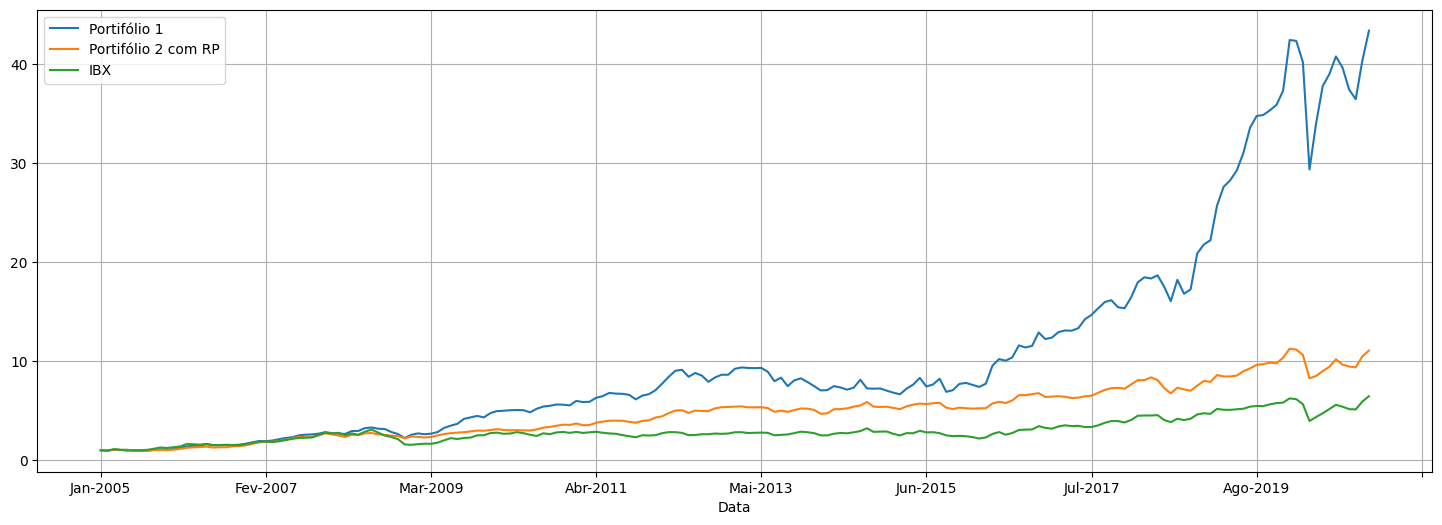

In [35]:
#Evolução dos portfólio 1 e do portifólio 2 com paridade de risco e de uma referência (IBX)
final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Portifólio 1'] = port_acc_vet1
final_df['Portifólio 2 com RP'] = port_acc_vet6
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

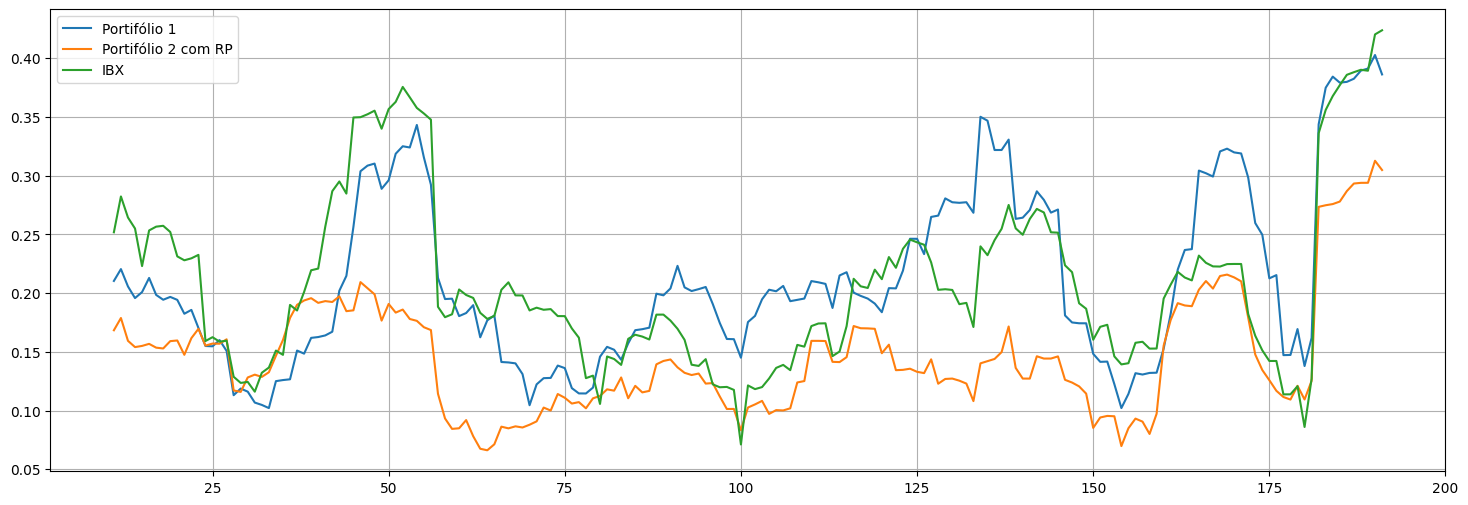

In [36]:
#Volatilidade dos últimos 12 meses dos portfólios e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Portifólio 1'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Portifólio 2 com RP'] = pd.Series(port_chg_vet6).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX'] = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);